In [1]:
import trimesh

dir(trimesh)

['ExceptionModule',
 'PointCloud',
 'Scene',
 'Trimesh',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'available_formats',
 'base',
 'boolean',
 'bounds',
 'caching',
 'collision',
 'comparison',
 'constants',
 'convex',
 'creation',
 'curvature',
 'decomposition',
 'exceptions',
 'exchange',
 'geometry',
 'graph',
 'grouping',
 'inertia',
 'interfaces',
 'intersections',
 'interval',
 'load',
 'load_mesh',
 'load_path',
 'load_remote',
 'nsphere',
 'parent',
 'path',
 'permutate',
 'points',
 'poses',
 'primitives',
 'proximity',
 'ray',
 'registration',
 'remesh',
 'rendering',
 'repair',
 'resolvers',
 'resources',
 'sample',
 'scene',
 'smoothing',
 'tol',
 'transform_points',
 'transformations',
 'triangles',
 'unitize',
 'units',
 'util',
 'version',
 'visual',
 'voxel']

In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(42)

In [3]:
DATA_DIR = tf.keras.utils.get_file("modelnet.zip",
                                   "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
                                   extract=True)

DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [4]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

(2048, 3)


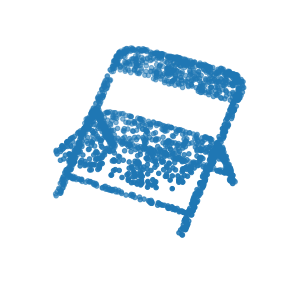

In [5]:
# 3d data의 표면의 점들을 random sample로 반환
points = mesh.sample(2048)
print(points.shape)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2]) # 산점도. 두 변수의 상관 관계를 직교 좌표계의 평면에 점을 표현
ax.set_axis_off() #축좌표 끄기
plt.show()

In [6]:
# dataset 나누기
# 훈련시에 필요한 좌표와 레이블, 테스트에 필요한 좌표와 레이블, 그리고 sofa, desk 등등 10가지의 class로 된 class map으로 나눔
def parse_dataset(num_points=2048):

    train_points =[]
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return(
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map
    )

In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [8]:
# 균일분포에서 임의의 값들을 생성하여 원폰 이미지에 noise를 입힌 후 shuffle을 하여 augmentation 진행
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    
    return points, label

In [9]:
len(train_points)

3126

In [14]:
len(train_labels)

3126

In [15]:
# dataset 나누고 섞어주기
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [17]:
# convnet과 densenet 만들어주기

# conv1D로 1d array 다루는 layer와 dense layer
# batch normalization은 gradient vanishing, exploding(기울기 소실, 폭주) 방지
# batchnormalization으로 각 layer에 들어가는 input을 normalize하여 layer의 학습을 가속화
# actiavation function은 흔한 relu 사용
def conv_bn(x, filters): #bn = batch normalization
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x) # padding valid는 default임
    x = layers.BatchNormalization(momentum=0.0)(x) # default는 0.99
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [13]:
# 직교화 시키기
# tf.keras.regularizers.OrthogonalRegularizer로 사용하면 됨
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features) # 단위행렬 만드는 함수

    def __call__(self, x):
        # reshape은 x를 지정한 shape으로 변경
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        # tensordot은 행렬곱을 연산. 선형대수 들어야겠다...
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [18]:
# tnet 구성하기
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    # 상수 값으로 텐서 생성 후 직교화
    
    #bias(성향, 편향) 가중치에 더해주는 상수
    bias = keras.initializers.Constant(np.eye(num_features).flatten()) #나중에 사용될 때 dense layer에 사용되므로 flatten으로 펴줌
    reg = OrthogonalRegularizer(num_features)

    # mlp 층 쌓기
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    # input이 어느 순서로 와도 동일한 순열불변을 위한 symmetric function
    # 이를 만족시키는 maxpooling 함수 사용
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [19]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

# local feature extraction
x = tnet(inputs, 3) # mini pointnet
# 3d data를 orthogonal하게 만들기 위해 mini pointnet 사용
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32) # 두 번째 mini pointnet. 이또한 canonical space로 보내기 위함
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x) #symmetric function으로 maxpooling 사용
# mlp 층을 통해 global feature extraction
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [20]:
# model training
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 131s 1s/step - loss: 3.4517 - sparse_categorical_accuracy: 0.3349 - val_loss: 159436439552.0000 - val_sparse_categorical_accuracy: 0.3192
Epoch 2/20
98/98 [==============================] - 129s 1s/step - loss: 2.7464 - sparse_categorical_accuracy: 0.4267 - val_loss: 214042.5156 - val_sparse_categorical_accuracy: 0.2909
Epoch 3/20
98/98 [==============================] - 129s 1s/step - loss: 2.6332 - sparse_categorical_accuracy: 0.4747 - val_loss: 527879649066791993344.0000 - val_sparse_categorical_accuracy: 0.4355
Epoch 4/20
98/98 [==============================] - 129s 1s/step - loss: 2.4204 - sparse_categorical_accuracy: 0.5528 - val_loss: 180328.7656 - val_sparse_categorical_accuracy: 0.3789
Epoch 5/20
98/98 [==============================] - 128s 1s/step - loss: 2.2931 - sparse_categorical_accuracy: 0.6177 - val_loss: 35005512333318422528.0000 - val_sparse_categorical_accuracy: 0.5629
Epoch 6/20
98/98 [===========================

1/1 [==============================] - 0s 57ms/step


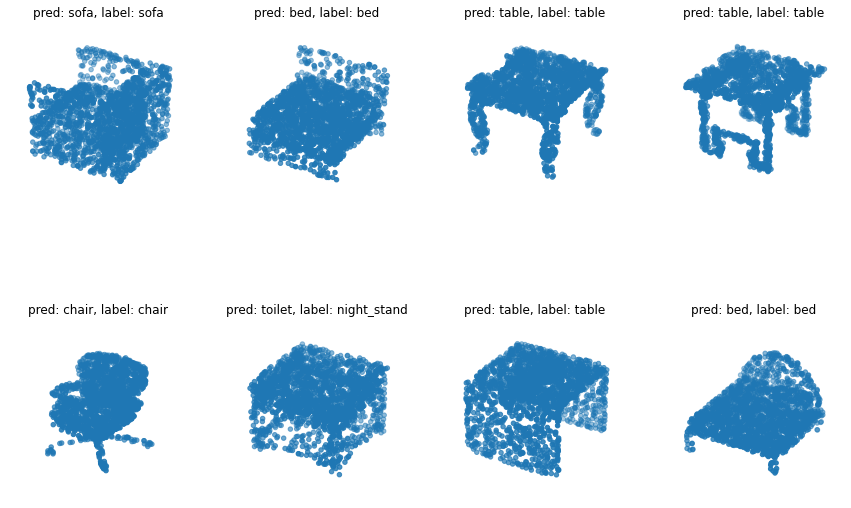

In [45]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# model training에 대한 prediction 진행과 visualization
# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()].split('\\')[-1]
            , CLASS_MAP[labels.numpy()[i]].split('\\')[-1]
        )
    )
    ax.set_axis_off()
plt.show()

In [42]:
CLASS_MAP[labels.numpy()[0]].split('\\')[-1]

'table'

In [49]:
# point cloud를 통해 mesh를 생성하기 위해 pyvista 설치
# %pip install pyvista

import pyvista as pv

dir(pv)

['AVSucdReader',
 'AmbiguousDataError',
 'Arrow',
 'Axes',
 'BMPReader',
 'BUILDING_GALLERY',
 'BYUReader',
 'BackgroundPlotter',
 'BasePlotter',
 'BaseReader',
 'BinaryMarchingCubesReader',
 'Box',
 'CGNSReader',
 'Camera',
 'CameraPosition',
 'Chart2D',
 'ChartBox',
 'ChartMPL',
 'ChartPie',
 'Circle',
 'CircularArc',
 'CircularArcFromNormal',
 'Color',
 'CompositeFilters',
 'Cone',
 'Cube',
 'Cylinder',
 'CylinderStructured',
 'DEMReader',
 'DICOMReader',
 'DataObject',
 'DataSet',
 'DataSetAttributes',
 'DataSetFilters',
 'Disc',
 'Dodecahedron',
 'EXAMPLES_PATH',
 'EnSightReader',
 'ExplicitStructuredGrid',
 'FIGURE_PATH',
 'FLOAT_FORMAT',
 'FONTS',
 'FacetReader',
 'FieldAssociation',
 'FluentReader',
 'GIFReader',
 'GLTFReader',
 'GPUInfo',
 'Grid',
 'HDFReader',
 'HDRReader',
 'ID_TYPE',
 'Icosahedron',
 'JPEGReader',
 'KochanekSpline',
 'Light',
 'Line',
 'MAX_N_COLOR_BARS',
 'MFIXReader',
 'MetaImageReader',
 'MissingDataError',
 'MultiBlock',
 'MultiBlockPlot3DReader',
 'Mul

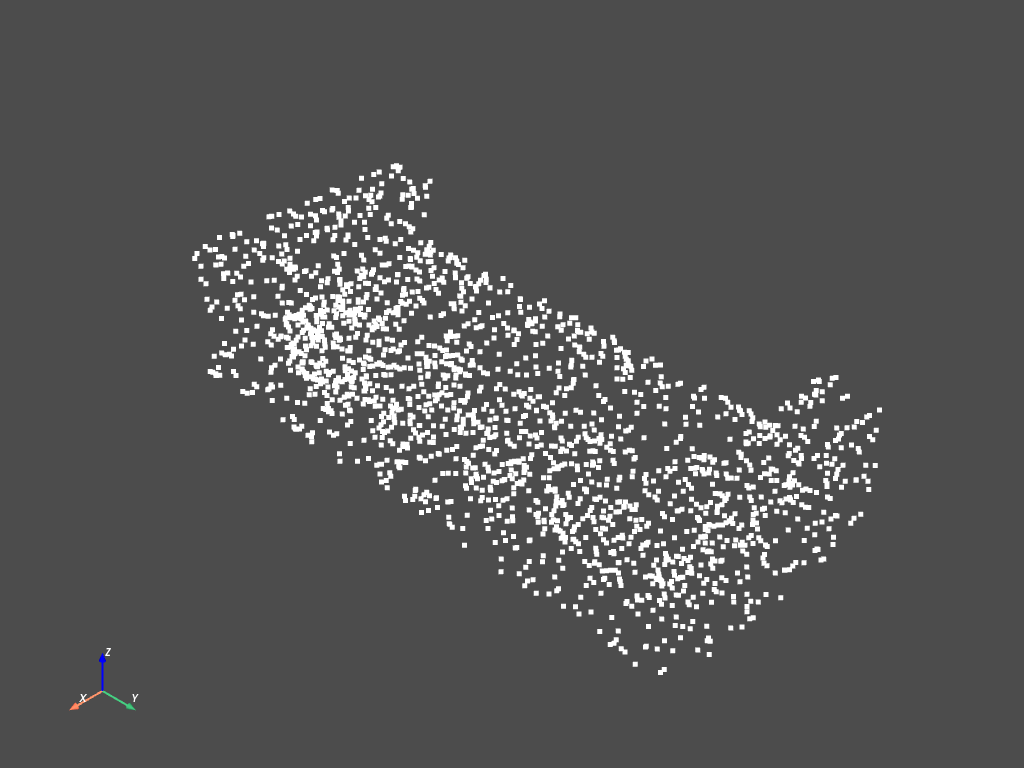

Extracting Geometry: 100%|██████████[00:00<00:00]


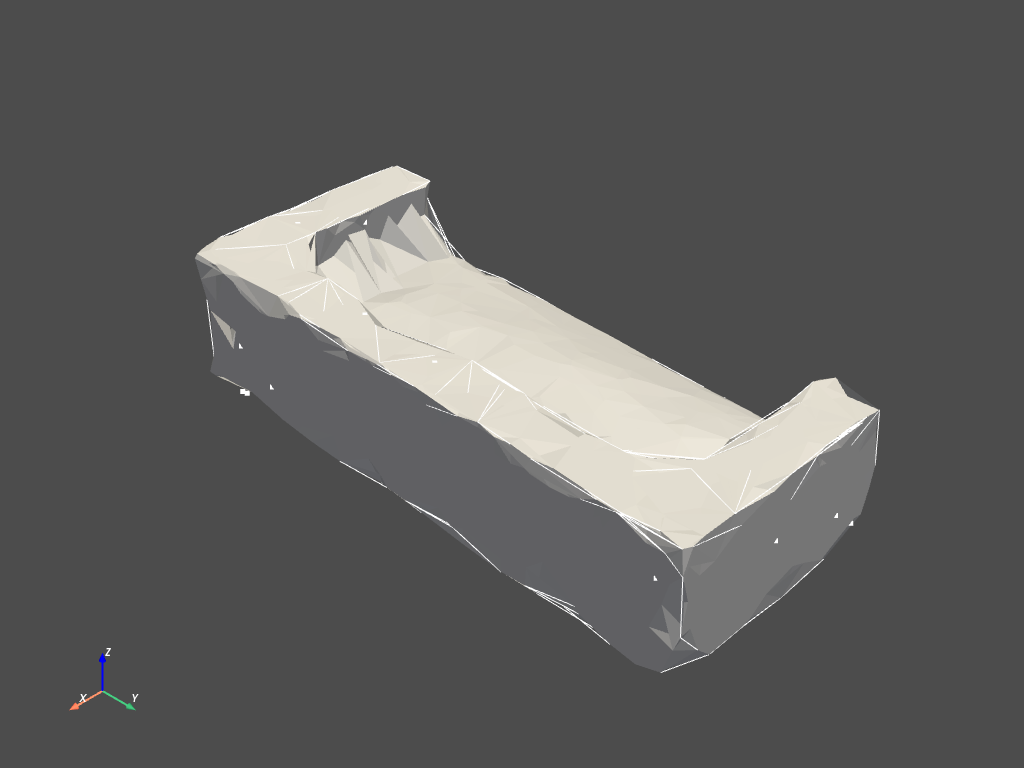

In [70]:
pc = pv.PolyData(points[0])
pc.plot()

# mesh의 3d 삼각측량을 구성하는 함수
# alpha값에 따라 출력을 제어하는 거리 값이 변함. 0 혹은 100은 거의 직육면체임.
volume = pc.delaunay_3d(alpha=6)
# 기하학 데이터 추출하기
shell = volume.extract_geometry(progress_bar=True)
shell.plot()